# Question 2: Political parties

We want to project the 149-dimensional data on only 2 dimensions.

First of all, we install and upload the packages.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import csv
import numpy.random
np.random.seed(42)   #set seed
import re
import pylab as pl
import pandas as pd

Import the data of the votes of 550 deputies:

In [6]:
votes_line = np.array([])

with open('votes_2003.txt','r') as txt:
    read_vote = csv.reader(txt, delimiter = '\n')
    for i in read_vote:
        votes_line = np.append(votes_line,i)

votes_string = np.array([])
for j in votes_line:
    votes_string = np.append(votes_string,j.split(' '))
votes_string = np.reshape(votes_string,(550,-1))               # 550 deputies
votes = votes_string.astype(np.float)

Import the data of the name and party affiliation of each deputy, in the same order encountered in the votes file: 

In [7]:
parties_line = np.array([])

with open('parties_2003.txt','r',encoding="utf-8") as txt:
    read_parties = csv.reader(txt, delimiter = '\t')      # it separates the name and affiliation by a tab
    
    
    for k in read_parties:
        parties_line = np.append(parties_line,k)
parties = parties_line.reshape(550,-1)[:,1]              

Now we create a vector of labels that will associate a unique colour to each party.

In [12]:
parties_set = list(set(parties))              # it creates a list containing the name of all parties
Parties = {}
for h in range(len(parties_set)):             # there are 17 parties
    Parties[parties_set[h]] = h
y = np.empty((550,1))
for l in range(550):
    y[l] = Parties[parties[l]]
y = y.flatten()

We use principal component analysis (PCA) and t-distributed stochastic neighbor embedding (t-SNE), 
to project the 149-dimensional voting data to 2 dimensions. 

We start using PCA. This method uses the correlation between dimensions and provides a minimum number of variables that keeps 
the maximum amount of variation/information about how the original data is distributed.

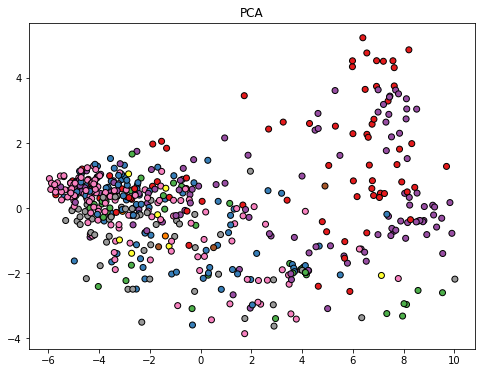

In [28]:
from sklearn import decomposition

#perform pca - project to 2 dimensions
pca = decomposition.PCA(n_components=2)
pca.fit(votes)
Y_pca = pca.transform(votes)

#plotting
fig = plt.figure(1, figsize=(8, 6))
fig.gca().scatter(Y_pca[:,0], Y_pca[:,1], c=y ,cmap=plt.cm.Set1, edgecolor="black")
plt.title('PCA')
plt.show()

Then we use now t-SNE. This approach minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding.

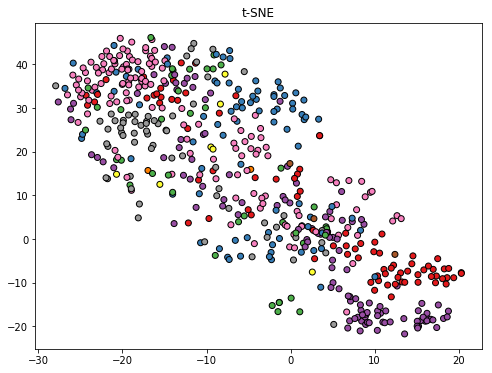

In [29]:
from sklearn import manifold

#perform tSNE
tsne = manifold.TSNE(n_components=2,random_state=42)
Y_tsne = tsne.fit_transform(votes)

#plotting
fig = plt.figure(1, figsize=(8, 6))
fig.gca().scatter(Y_tsne[:,0], Y_tsne[:,1], c=y, cmap=plt.cm.Set1, edgecolor="black")
plt.title('t-SNE')
plt.show()

We would expect that t-SNE would be a better projection/visualisation technique for this problem. 
PCA is a linear algorithm, and focuses on placing dissimilar data points far apart in the lower dimension representation, 
while TSNE preserves local structure of the data points. In the PCA plot, there is no obvious separate blob-like clusters.
tSNE seems to do a better job at grouping parties, and the clusters have separated more. However, overall it seems that the algorithms do not separate the parties in a meaningful way.

# Clustering 


 Based on each embedding for PCA and t-SNE previously obtained we do clustering to identify groups of politicians with similar voting behaviour. We try Kmeans and Gaussian Mixtures.
 
To compare the quality of each method, we calculate the following measure of uncertainty:
$
    \sum_j \sqrt{N_j} \times (\frac{N_j^0}{N_j} - 0.5)^2,
$
where $N_j$ is number of deputies of the party $j$ and $N_j^0$ is the number of deputies of the party $j$ assigned to $0^{th}$ group. The term $(\frac{N_j^0}{N_j} - 0.5)^2$ is a measure of of distance between our model assignment and a random guess and the scaling factor $ \sqrt{N_j}$ is present since in parties with more deputies the measure of uncertainty gives more information.

 
First, we start using the K-means algorithm for PCA:

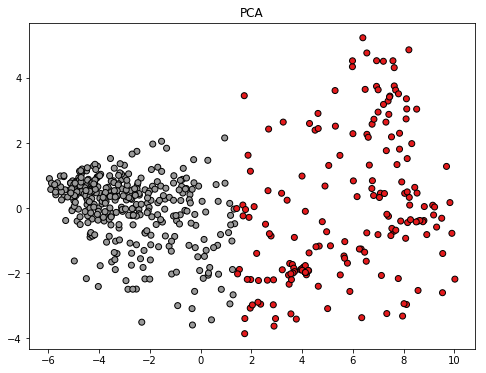

In [34]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2, random_state = 42).fit(Y_pca) # random state is the same seed.
predicted_c_kmeans = kmeans.labels_

fig = plt.figure(1, figsize=(8, 6))
fig.gca().scatter(Y_pca[:,0], Y_pca[:,1], c=predicted_c_kmeans, cmap=plt.cm.Set1, edgecolor="black")
plt.title('PCA')
plt.show()

In [36]:
gov = np.array([])
for i in range(550):
    if(predicted_c_kmeans[i] == 0):
        gov = np.append(gov,parties[i])

error = []
group = {}
for j in parties_set:
    predict_count = [predicted_c_kmeans[i] for i in range(550) if parties[i] == j]
    parties_num = 0
    for i in range(550):
        if(parties[i] == j):
            parties_num = parties_num + 1 
    if(np.sum(predict_count)/parties_num >= 0.5): 
        group[j] = 1
    else:
        group[j] = 0
    print(j,': ',np.sum(predict_count), parties_num)
    
    error = np.append(error,[np.sqrt(parties_num)*(np.sum(predict_count)/parties_num - 0.5)**2])
print('\n')
print('The measure of uncertainty is:', np.sum(error))
print('\n')
print(group) 

PPS :  19 20
PSDB :  15 66
PMDB :  63 76
PCdoB :  11 11
PSB :  28 33
PRONA :  0 7
PL :  33 39
PFL :  12 83
PMN :  2 2
PV :  5 6
PSC :  1 1
S.Part. :  0 1
PP :  2 2
PT :  89 97
PPB :  31 44
PDT :  12 17
PTB :  41 45


The measure of uncertainty is: 11.322849203665966


{'PPS': 1, 'PSDB': 0, 'PMDB': 1, 'PCdoB': 1, 'PSB': 1, 'PRONA': 0, 'PL': 1, 'PFL': 0, 'PMN': 1, 'PV': 1, 'PSC': 1, 'S.Part.': 0, 'PP': 1, 'PT': 1, 'PPB': 1, 'PDT': 1, 'PTB': 1}


We used K-means to classify deputies into two groups. 
We repeat this classification for the t-SNE and the Gaussian mixtures for PCA and t-SNE and we compare quantitatively the quality of each method using the measure of uncertainty previously derived.

Now we use the K-means algorithm for t-SNE:

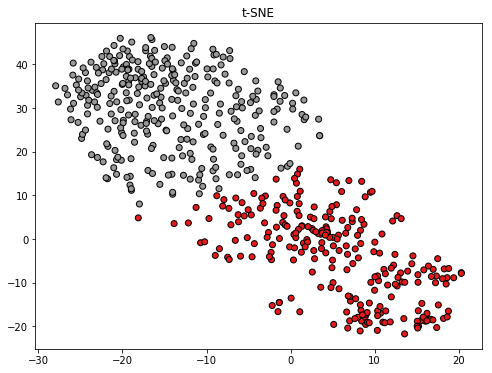

In [37]:
kmeans = KMeans(n_clusters = 2, random_state = 42).fit(Y_tsne)   # random state is the same seed.
predicted_c_kmeans = kmeans.labels_

fig = plt.figure(1, figsize=(8, 6))
fig.gca().scatter(Y_tsne[:,0], Y_tsne[:,1], c=predicted_c_kmeans, cmap=plt.cm.Set1, edgecolor="black")
plt.title('t-SNE')
plt.show()

In [38]:
gov = np.array([])
for i in range(550):
    if(predicted_c_kmeans[i] == 0):
        gov = np.append(gov,parties[i])

error = []
group = {}
for j in parties_set:
    predict_count = [predicted_c_kmeans[i] for i in range(550) if parties[i] == j]
    parties_num = 0
    for i in range(550):
        if(parties[i] == j):
            parties_num = parties_num + 1 
    if(np.sum(predict_count)/parties_num >= 0.5): 
        group[j] = 1
    else:
        group[j] = 0
    print(j,': ',np.sum(predict_count), parties_num)
    error = np.append(error,[np.sqrt(parties_num)*(np.sum(predict_count)/parties_num - 0.5)**2])
print('\n')
print('The measure of uncertainty is:', np.sum(error))
print('\n')
print(group)

PPS :  18 20
PSDB :  9 66
PMDB :  48 76
PCdoB :  11 11
PSB :  24 33
PRONA :  0 7
PL :  28 39
PFL :  6 83
PMN :  2 2
PV :  5 6
PSC :  1 1
S.Part. :  0 1
PP :  1 2
PT :  89 97
PPB :  17 44
PDT :  11 17
PTB :  36 45


The measure of uncertainty is: 9.312533413438498


{'PPS': 1, 'PSDB': 0, 'PMDB': 1, 'PCdoB': 1, 'PSB': 1, 'PRONA': 0, 'PL': 1, 'PFL': 0, 'PMN': 1, 'PV': 1, 'PSC': 1, 'S.Part.': 0, 'PP': 1, 'PT': 1, 'PPB': 0, 'PDT': 1, 'PTB': 1}


Now we use Gaussian mixtures for PCA:

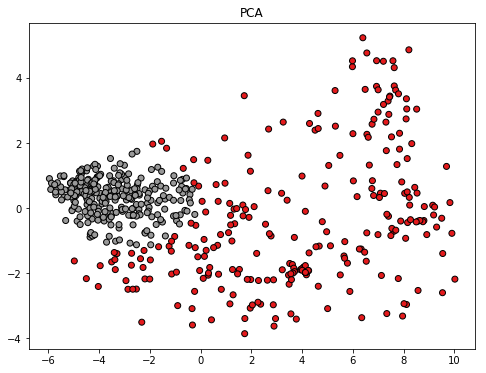

In [41]:
from sklearn.mixture import GaussianMixture

# Performing Gaussian mixtures
model = GaussianMixture(n_components=2,random_state=0)
model.fit(Y_pca)
predicted_c_gaussian = model.predict(Y_pca)

# plotting
fig = plt.figure(1, figsize=(8, 6))
fig.gca().scatter(Y_pca[:,0], Y_pca[:,1], c=predicted_c_gaussian, cmap=plt.cm.Set1, edgecolor="black")
plt.title('PCA')
plt.show()

In [42]:
gov = np.array([])
for i in range(550):
    if(predicted_c_gaussian[i] == 1):
        gov = np.append(gov,parties[i])

error = []
group = {}
for j in parties_set:
    predict_count = [predicted_c_gaussian[i] for i in range(550) if parties[i] == j]
    parties_num = 0
    for i in range(550):
        if(parties[i] == j):
            parties_num = parties_num + 1
    if(np.sum(predict_count)/parties_num >= 0.5): 
        group[j] = 1
    else:
        group[j] = 0
    print(j,': ',np.sum(predict_count), parties_num)
    error = np.append(error,[np.sqrt(parties_num)*(np.sum(predict_count)/parties_num - 0.5)**2])
print('\n')
print('The measure of uncertainty is:', np.sum(error))
print('\n')
print(group)

PPS :  19 20
PSDB :  10 66
PMDB :  43 76
PCdoB :  7 11
PSB :  21 33
PRONA :  0 7
PL :  31 39
PFL :  7 83
PMN :  2 2
PV :  3 6
PSC :  1 1
S.Part. :  0 1
PP :  0 2
PT :  86 97
PPB :  17 44
PDT :  10 17
PTB :  31 45


The measure of uncertainty is: 7.913122212042119


{'PPS': 1, 'PSDB': 0, 'PMDB': 1, 'PCdoB': 1, 'PSB': 1, 'PRONA': 0, 'PL': 1, 'PFL': 0, 'PMN': 1, 'PV': 1, 'PSC': 1, 'S.Part.': 0, 'PP': 0, 'PT': 1, 'PPB': 0, 'PDT': 1, 'PTB': 1}


Then we use Gaussian mixtures for t-SNE:

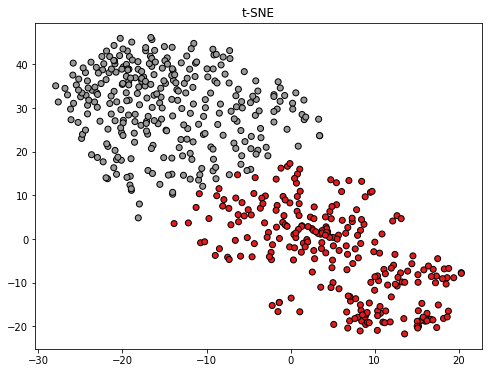

In [45]:
# Performing Gaussian mixtures
model = GaussianMixture(n_components=2, random_state=0)
model.fit(Y_tsne)
predicted_c_gaussian = model.predict(Y_tsne)

# plotting
fig = plt.figure(1, figsize=(8, 6))
fig.gca().scatter(Y_tsne[:,0], Y_tsne[:,1], c=predicted_c_gaussian, cmap=plt.cm.Set1, edgecolor="black")
plt.title('t-SNE')
plt.show()

In [46]:
gov = np.array([])
for i in range(550):
    if(predicted_c_gaussian[i] == 1):
        gov = np.append(gov,parties[i])

error = []
group = {}
for j in parties_set:
    predict_count = [predicted_c_gaussian[i] for i in range(550) if parties[i] == j]
    parties_num = 0
    for i in range(550):
        if(parties[i] == j):
            parties_num = parties_num + 1 
    if(np.sum(predict_count)/parties_num >= 0.5): 
        group[j] = 1
    else:
        group[j] = 0
    print(j,': ',np.sum(predict_count), parties_num)
    error = np.append(error,[np.sqrt(parties_num)*(np.sum(predict_count)/parties_num - 0.5)**2])
print('\n')
print('The measure of uncertainty is:', np.sum(error))
print('\n')
print(group)

PPS :  18 20
PSDB :  8 66
PMDB :  47 76
PCdoB :  11 11
PSB :  23 33
PRONA :  0 7
PL :  27 39
PFL :  6 83
PMN :  2 2
PV :  5 6
PSC :  1 1
S.Part. :  0 1
PP :  0 2
PT :  88 97
PPB :  17 44
PDT :  11 17
PTB :  36 45


The measure of uncertainty is: 9.50551132599908


{'PPS': 1, 'PSDB': 0, 'PMDB': 1, 'PCdoB': 1, 'PSB': 1, 'PRONA': 0, 'PL': 1, 'PFL': 0, 'PMN': 1, 'PV': 1, 'PSC': 1, 'S.Part.': 0, 'PP': 0, 'PT': 1, 'PPB': 0, 'PDT': 1, 'PTB': 1}


It turns out that the lowest measure of uncertainty is when we use a Gaussian Mixtures model for PCA embedding. The predicted clustering result is:

Group 1: {PMDB,PTB,PPS, PCdoB, PT, PMN, PL, PV, PSC, PDT, PSB}

Group 2: {S.Part., PSDB, PFL, PRONA, PPB, PP}

In [53]:
Group1=['PMDB','PTB','PPS','PCdoB','PT','PMN','PL','PV','PSC','PDT','PSB']
parties_list = list(parties)
Group1_count = 0
for j in Group1:
    Group1_count = Group1_count + parties_list.count(j)
print('The number of  deputies in Group 1 is ', Group1_count,' \n')
print('The number of  deputies in Group 2 is ', 550 - Group1_count)

The number of  deputies in Group 1 is  347  

The number of  deputies in Group 2 is  203


Based on this findings, we assume that all parties in Group 1 belong to the government, since it has more deputies, while the 
other parties contained in Group 2 belong to the opposition.